In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd



## Bayesian function estimation

Now here instead of wanting to know the value of a given variable, we want to know an entire function, let's say $E(x)$. This is different from evaluating $E(x)$ point-wise using the techniques in the other notebook. The reason we want to look at the function level is that our priors generally operate on functions, not on individual points. 


We are allowed to gather data about $E(x)$ by making evaluations $\bar{E}(x_i)$. We need some degree of belief about the data $\bar{E}(x_i)$, which is encoded in $\rho(\bar{E}(x_i) | E(x))$. That is, if we knew $E(x)$, what would be the expected distribution of $\bar{E}(x)$? 

We will demonstrate this for a case where we know the underlying function. We will apply analysis techniques to *just the data* and check whether we can recover the original function.

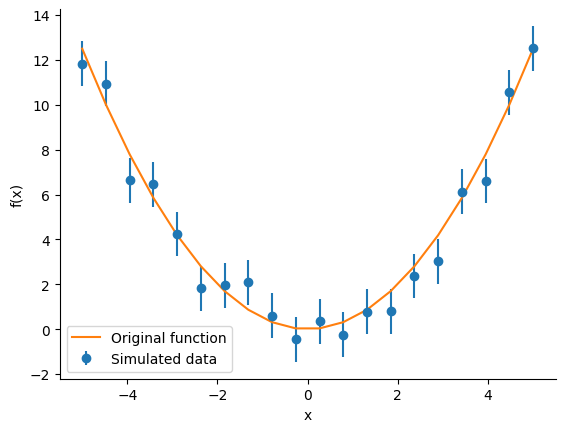

In [2]:
x = np.linspace(-5,5,20)
alpha = 0.5
f = alpha*x**2
sigma = 1
y = f + np.random.normal(0,sigma,len(x))
plt.errorbar(x,y,yerr=np.ones_like(x)*sigma, marker='o', linestyle='none', label='Simulated data')
plt.plot(x,f, label='Original function')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
sns.despine()

Bayes' theorem says
$$
\rho(f(x) | \{\bar{E}(x_i)\}) \propto \rho(\{\bar{E}(x_i)|f(x)\}) \rho(f(x))
$$

Since we know that the data has the correct expectation value plus some random noise $\sigma$, we know that:
$$
\rho(\{\bar{E}(x_i)|f(x)\}) \propto \prod_i \exp( -\frac{(\bar{E}(x_i)-f(x))^2}{2\sigma^2})
$$

Now we have to decide $\rho(f(x))$. This is highly situation dependent, but keep in mind that it *cannot* depend on the data that we have gathered. It needs to be dependent on external things. 

Let's keep it simple; suppose that we only know that a general quadratic function will describe this function. 
So $\rho(f(x))$ is a constant if the taylor series of $f(x)$ truncates after three terms, and 0 otherwise. 
Therefore, $f(x) = a + bx + cx^2$. We can already complicate matters by forcing $c$ to be greater than zero etc. 
However, to help us with the plots, let's assume that we know that $b=0$. We will thus just consider $f(x) = a+cx^2$.


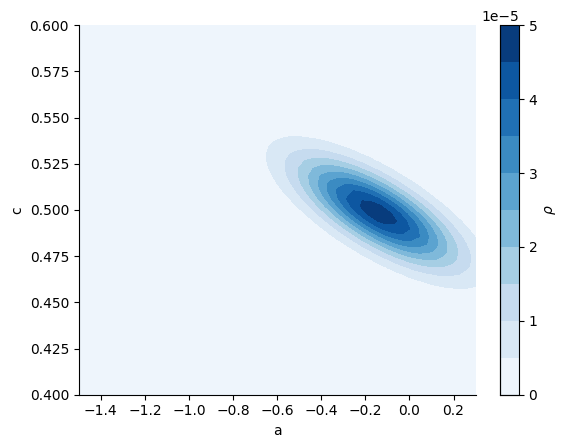

In [4]:
a = np.linspace(0-1.5,0+.3,50)
c = np.linspace(0.5-.1,.5+.1,50)
A,C = np.meshgrid(a,c)
chi2 = np.zeros_like(A.flatten()) #the log-likehood is the same as chi2
for i, (a, c) in enumerate(zip(A.flatten(),C.flatten())):
    chi2[i] = np.sum(-((y - a - c*x*x)**2)/(sigma**2))
chi2 = chi2.reshape(A.shape)


plt.figure()
cmap = plt.contourf(A,C,np.exp(chi2), levels=10, cmap='Blues')
plt.colorbar(cmap, label = r"$\rho$")
plt.xlabel("a")
plt.ylabel("c")
sns.despine()

Note that the distribution function is **correlated** so you cannot represent it as $a$ having some uncertainty plus $c$ having some uncertainty. This correlation is important for estimating properties accurately. 

We could sample from that distribution, probably using Metropolis Monte Carlo or Gibbs or similar. However, often bootstrap is a pretty good approximation:


[0.08792594083912164, -0.26642725672906964, -0.3604350048179242, 0.02614018662010742, 0.013031603476831188, 0.08066930907650027, 0.021077478300675856, -0.31766316022002966, 5.207427810383081e-05, 0.4923052958576403, -0.32062711731691607, -0.7133447718040268, -0.2972877878952941, -0.06480667123224138, -0.3826081695136624, 0.33713092024699365, -0.26013747375807017, 0.07942560711286129, 0.1718642046812251, -0.05704441497943924, -0.2542997714537656, -0.23311021705826446, -0.40066722334566307, 0.0684043327220144, -0.150181505500453, -0.06976541935097458, 0.10510145828526246, 0.18496312486847255, 0.03369698924774245, -0.03874163841464795, -0.1341179326681851, -0.32044181615876255, -0.22603454345216642, -0.007430660291768643, 0.09471628851404579, 0.05940895244291511, 0.2275046111762298, -0.1683909317974075, -0.4114821872169102, -0.4656953511600745, -0.09151806247694874, -0.33864717130441596, -0.28342694595801343, -0.19704878045578733, -0.08788124226050564, -0.19635601329306385, -0.68988494806

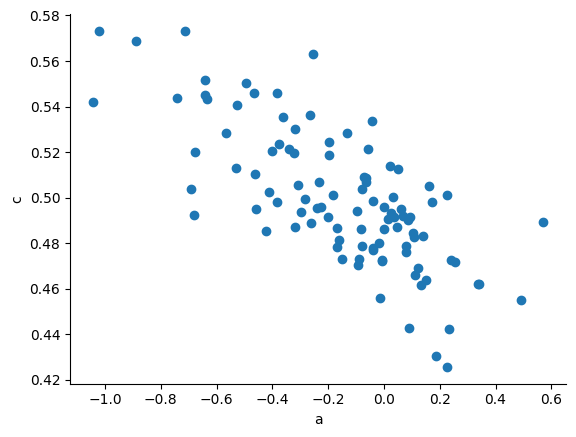

In [6]:
import statsmodels.formula.api as sm
df = {'x':x, 'y':y, 'sigma':np.ones_like(x)*sigma}
df = pd.DataFrame(df)
dfs = df.sample(10, replace=True)

a = []
c = []
for i in range(100):
    dfs = df.sample(10, replace=True)
    model = sm.ols('y ~ I(x**2)', data=dfs).fit()
    a.append(model.params['Intercept'])
    c.append(model.params['I(x ** 2)'])
print(a)
plt.scatter(a,c)
plt.xlabel("a")
plt.ylabel("c")
sns.despine()

Now we can proceed to estimating the minimum of a general quadratic. 

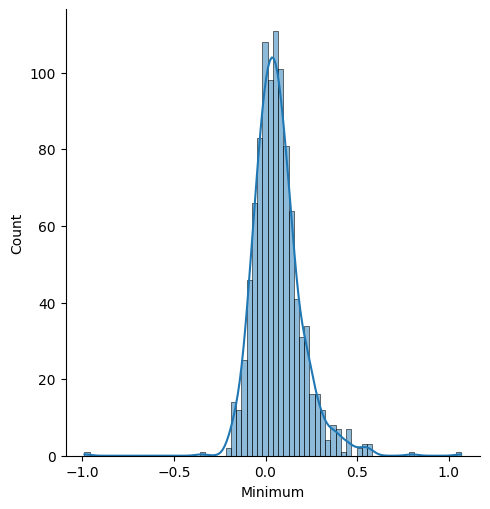

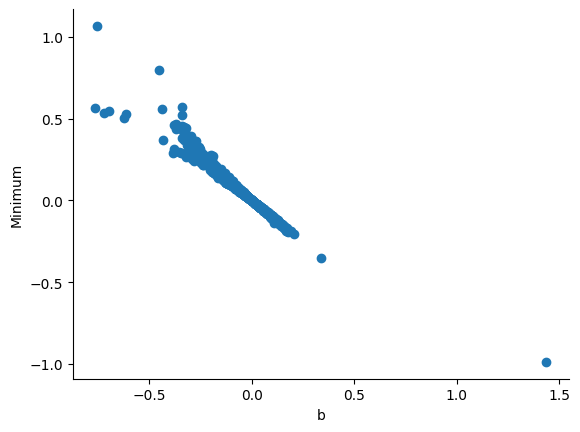

In [7]:
df = {'x':x, 'y':y, 'sigma':np.ones_like(x)*sigma}
df = pd.DataFrame(df)

a = []
b = []
c = []
for i in range(1000):
    dfs = df.sample(10, replace=True)
    model = sm.ols('y ~ x + I(x**2)', data=dfs).fit()
    a.append(model.params['Intercept'])
    b.append(model.params['x'])
    c.append(model.params['I(x ** 2)'])
a = np.asarray(a)
b = np.asarray(b)
c = np.asarray(c)
minimum = -b/(2*c)
sns.displot(minimum, kde=True)
plt.xlabel("Minimum")
sns.despine()


plt.figure()
plt.scatter(b, minimum)
plt.xlabel("b")
plt.ylabel("Minimum")
sns.despine()